# NYC Taxi Fare Prediction – K-Nearest Neighbors (KNN)

This notebook uses a K-Nearest Neighbors (KNN) Regressor to predict taxi fares based on NYC Yellow Taxi trip data. It loads the dataset, performs data cleaning and feature engineering, explores key patterns in the data, and prepares features such as distance, duration, and time-related variables. After preprocessing, the KNN model is trained, tuned, and evaluated using regression performance metrics, and the final model is saved for future fare predictions.

## 1. Imports

In [1]:
import glob
import time
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)

import joblib

sns.set(style='whitegrid')
pd.set_option('display.max_columns', 100)


## 2. Data Loading

This section loads one or more NYC Yellow Taxi CSV files from the `data/` folder and concatenates them into a single DataFrame called `combined_data`.


In [2]:
data_path = Path('data')
csv_files = sorted(list(data_path.glob('*.csv')))
print(f"Found {len(csv_files)} CSV files:")
for f in csv_files:
    print(' -', f)

if not csv_files:
    raise FileNotFoundError("No CSV files found in 'data/' folder. Please add taxi data there.")

dfs = []
for file in csv_files:
    print(f'Loading {file} ...')
    df_part = pd.read_csv(file)
    dfs.append(df_part)



combined_data = pd.concat(dfs, ignore_index=True)
print('Combined shape:', combined_data.shape)
combined_data.head()

Found 4 CSV files:
 - data/yellow_tripdata_2015-01.csv
 - data/yellow_tripdata_2016-01.csv
 - data/yellow_tripdata_2016-02.csv
 - data/yellow_tripdata_2016-03.csv
Loading data/yellow_tripdata_2015-01.csv ...
Loading data/yellow_tripdata_2016-01.csv ...
Loading data/yellow_tripdata_2016-02.csv ...
Loading data/yellow_tripdata_2016-03.csv ...
Combined shape: (47248845, 20)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,RatecodeID
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1.0,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05,NaN
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1.0,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80,NaN
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1.0,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80,NaN
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1.0,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80,NaN
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1.0,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30,NaN


### 2.1 Basic Structure Overview
We inspect column names, dtypes, and a quick statistical summary.

In [3]:
combined_data.info()

combined_data.describe(include='all').T.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47248845 entries, 0 to 47248844
Data columns (total 20 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               int64  
 1   tpep_pickup_datetime   object 
 2   tpep_dropoff_datetime  object 
 3   passenger_count        int64  
 4   trip_distance          float64
 5   pickup_longitude       float64
 6   pickup_latitude        float64
 7   RateCodeID             float64
 8   store_and_fwd_flag     object 
 9   dropoff_longitude      float64
 10  dropoff_latitude       float64
 11  payment_type           int64  
 12  fare_amount            float64
 13  extra                  float64
 14  mta_tax                float64
 15  tip_amount             float64
 16  tolls_amount           float64
 17  improvement_surcharge  float64
 18  total_amount           float64
 19  RatecodeID             float64
dtypes: float64(14), int64(3), object(3)
memory usage: 7.0+ GB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
VendorID,47248845.0,NaN,NaN,NaN,1.52957,0.499125,1.0,1.0,2.0,2.0,2.0
tpep_pickup_datetime,47248845,9568974,2015-01-05 09:39:49,94,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tpep_dropoff_datetime,47248845,9581794,2015-01-02 00:00:00,142,NaN,NaN,NaN,NaN,NaN,NaN,NaN
passenger_count,47248845.0,NaN,NaN,NaN,1.66704,1.322092,0.0,1.0,1.0,2.0,9.0
trip_distance,47248845.0,NaN,NaN,NaN,7.508418,6487.65834,-3390583.8,1.0,1.69,3.09,19072628.8
pickup_longitude,47248845.0,NaN,NaN,NaN,-72.764518,9.38183,-161.698669,-73.991661,-73.981552,-73.966568,94.643867
pickup_latitude,47248845.0,NaN,NaN,NaN,40.084705,5.168528,-77.03949,40.736115,40.753349,40.767788,404.700012
RateCodeID,12748986.0,NaN,NaN,NaN,1.036901,0.673224,1.0,1.0,1.0,1.0,99.0
store_and_fwd_flag,47248845,2,N,46938162,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dropoff_longitude,47248845.0,NaN,NaN,NaN,-72.825011,9.150215,-740.166687,-73.991203,-73.979622,-73.96225,85.274025


## 3. Feature Engineering & Initial Exploration

We convert pickup and dropoff timestamps to datetimes and create additional features:
- `pickup_datetime`, `dropoff_datetime`
- `trip_duration` in minutes
- `hour` of pickup
- `day_of_week` (0=Monday, 6=Sunday)
- `speed_mph` as an approximate average speed


In [4]:
# Ensure expected columns exist (typical TLC schema)
expected_cols = ['tpep_pickup_datetime', 'tpep_dropoff_datetime',
                 'trip_distance', 'fare_amount',
                 'pickup_longitude', 'pickup_latitude',
                 'dropoff_longitude', 'dropoff_latitude']
missing = [c for c in expected_cols if c not in combined_data.columns]
if missing:
    print('Warning: missing expected columns:', missing)

# Convert datetimes
combined_data['pickup_datetime'] = pd.to_datetime(combined_data['tpep_pickup_datetime'])
combined_data['dropoff_datetime'] = pd.to_datetime(combined_data['tpep_dropoff_datetime'])

# Trip duration in minutes
combined_data['trip_duration'] = (
    combined_data['dropoff_datetime'] - combined_data['pickup_datetime']
).dt.total_seconds() / 60

# Temporal features
combined_data['hour'] = combined_data['pickup_datetime'].dt.hour
combined_data['day_of_week'] = combined_data['pickup_datetime'].dt.dayofweek

# Approximate speed (mph)
combined_data['speed_mph'] = combined_data['trip_distance'] / (combined_data['trip_duration'] / 60)

combined_data[['trip_distance', 'trip_duration', 'hour', 'day_of_week', 'speed_mph']].head()

,trip_distance,trip_duration,hour,day_of_week,speed_mph
0,1.59,18.050000,19,3,5.285319
1,3.30,19.833333,20,5,9.983193
2,1.80,10.050000,20,5,10.746269
3,0.50,1.866667,20,5,16.071429
4,3.00,19.316667,20,5,9.318378


### 3.1 Distributions of Key Variables
We examine the distributions of fare, distance, and duration on the raw combined data.

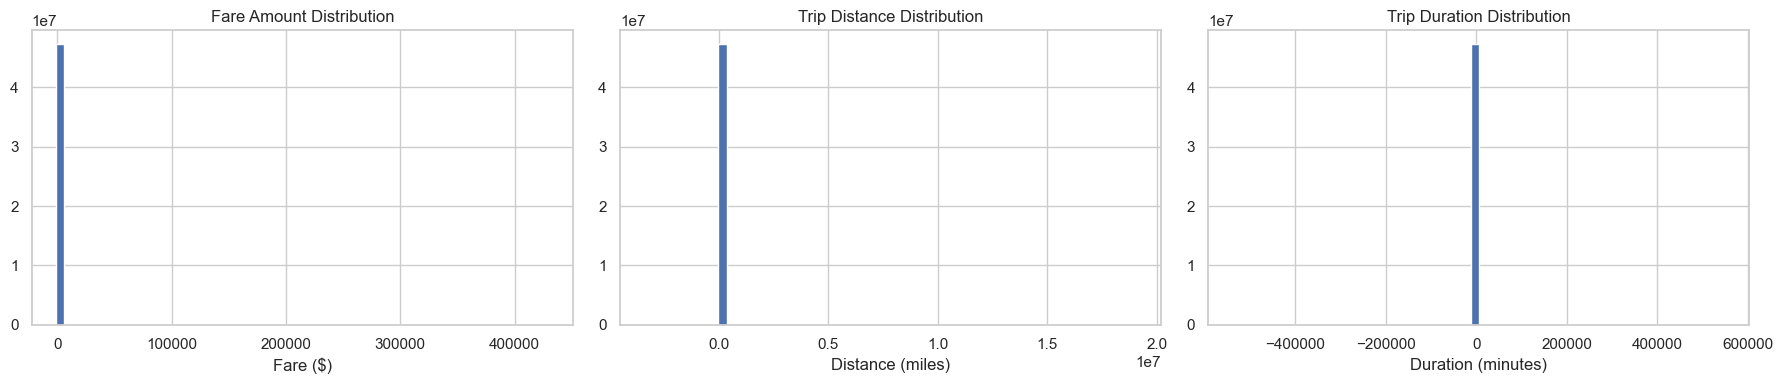

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

axes[0].hist(combined_data['fare_amount'].dropna(), bins=60)
axes[0].set_title('Fare Amount Distribution')
axes[0].set_xlabel('Fare ($)')

axes[1].hist(combined_data['trip_distance'].dropna(), bins=60)
axes[1].set_title('Trip Distance Distribution')
axes[1].set_xlabel('Distance (miles)')

axes[2].hist(combined_data['trip_duration'].dropna(), bins=60)
axes[2].set_title('Trip Duration Distribution')
axes[2].set_xlabel('Duration (minutes)')

plt.tight_layout()
plt.show()

### 3.2 Average Fare by Hour and Day of Week
These aggregations help visualize temporal patterns in pricing.

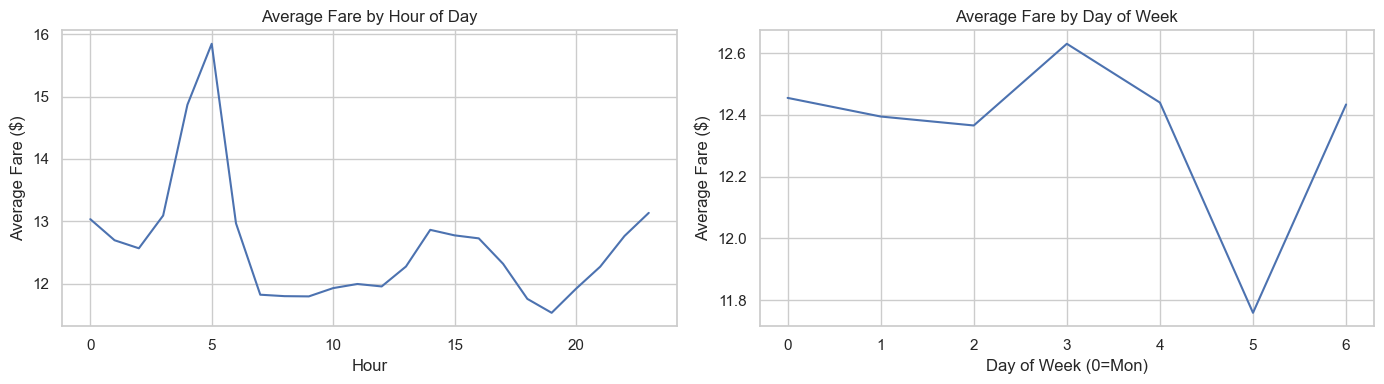

In [6]:
# Drop obviously invalid fares before aggregation
tmp = combined_data[(combined_data['fare_amount'] > 0) & (combined_data['trip_distance'] > 0)].copy()

fare_by_hour = tmp.groupby('hour')['fare_amount'].mean()
fare_by_dow = tmp.groupby('day_of_week')['fare_amount'].mean()

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
fare_by_hour.plot(ax=axes[0])
axes[0].set_title('Average Fare by Hour of Day')
axes[0].set_xlabel('Hour')
axes[0].set_ylabel('Average Fare ($)')

fare_by_dow.plot(ax=axes[1])
axes[1].set_title('Average Fare by Day of Week')
axes[1].set_xlabel('Day of Week (0=Mon)')
axes[1].set_ylabel('Average Fare ($)')

plt.tight_layout()
plt.show()

## 4. Data Cleaning

We now clean the data to remove invalid or extreme records:
- Drop duplicates
- Drop rows with missing key values
- Keep only trips inside a reasonable NYC coordinate bounding box
- Remove non-positive or extreme durations, distances, and fares


In [7]:
data = combined_data.copy()

# Remove duplicates
data = data.drop_duplicates()

# Drop rows missing key info
key_cols = ['fare_amount', 'trip_distance', 'trip_duration',
            'pickup_longitude', 'pickup_latitude',
            'dropoff_longitude', 'dropoff_latitude']
data = data.dropna(subset=key_cols)

# Filter to approximate NYC bounds
lon_min, lon_max = -74.3, -73.7
lat_min, lat_max = 40.5, 40.9
coord_mask = (
    data['pickup_longitude'].between(lon_min, lon_max) &
    data['dropoff_longitude'].between(lon_min, lon_max) &
    data['pickup_latitude'].between(lat_min, lat_max) &
    data['dropoff_latitude'].between(lat_min, lat_max)
)
data = data[coord_mask]

# Remove non-positive values
data = data[(data['trip_distance'] > 0) & (data['fare_amount'] > 0) & (data['trip_duration'] > 0)]

# Remove extremely long trips (> 5 hours)
data = data[data['trip_duration'] <= 300]

# Optional: cap fares at 95th percentile to trim extreme high fares
fare_95 = data['fare_amount'].quantile(0.95)
data = data[data['fare_amount'] <= fare_95]

print('Cleaned data shape:', data.shape)
data[['fare_amount', 'trip_distance', 'trip_duration']].describe()

Cleaned data shape: (43857584, 26)


,fare_amount,trip_distance,trip_duration
count,4.385758e+07,4.385758e+07,4.385758e+07
mean,1.051804e+01,6.757157e+00,1.173160e+01
std,5.902871e+00,6.226357e+03,7.488789e+00
min,1.000000e-02,1.000000e-02,1.666667e-02
25%,6.500000e+00,1.000000e+00,6.216667e+00
50%,9.000000e+00,1.600000e+00,1.005000e+01
75%,1.300000e+01,2.780000e+00,1.558333e+01
max,3.250000e+01,1.907263e+07,2.997833e+02


### 4.1 Correlation Heatmap (Cleaned Sample)
We examine correlations among numeric variables on a sampled subset of the cleaned data.

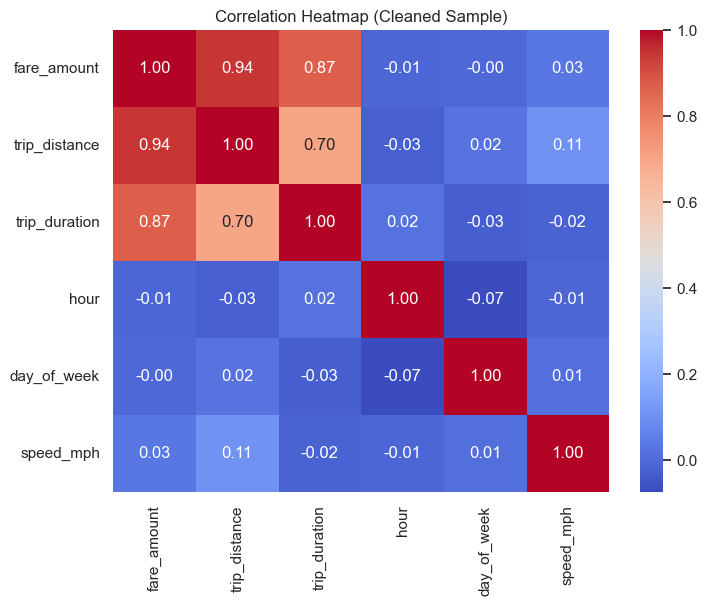

In [8]:
num_cols = ['fare_amount', 'trip_distance', 'trip_duration', 'hour', 'day_of_week', 'speed_mph']

sample_for_corr = data[num_cols].dropna().sample(n=min(50000, len(data)), random_state=42)
corr = sample_for_corr.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap (Cleaned Sample)')
plt.show()

## 5. K-Nearest Neighbors (KNN) Regression Model

In this section we build a KNN regression model to predict `fare_amount`, mirroring the modeling structure of the Random Forest notebook but using a distance-based algorithm.


### 5.1 Feature Selection and Outlier Trimming

In [9]:
# Define target and feature set similar to the team pipeline
target_col = 'fare_amount'

feature_cols = [
    'trip_distance',
    'trip_duration',
    'hour',
    'day_of_week',
    'pickup_longitude',
    'pickup_latitude',
]

# Include passenger_count and RateCodeID if available
if 'passenger_count' in data.columns:
    feature_cols.append('passenger_count')
if 'RatecodeID' in data.columns:
    feature_cols.append('RatecodeID')
elif 'RateCodeID' in data.columns:
    feature_cols.append('RateCodeID')

X_reg = data[feature_cols].copy()
y_reg = data[target_col].copy()

# Trim extreme fares (5th to 95th percentile)
fare_q05 = y_reg.quantile(0.05)
fare_q95 = y_reg.quantile(0.95)
mask = (y_reg >= fare_q05) & (y_reg <= fare_q95)

X_reg_clean = X_reg[mask]
y_reg_clean = y_reg[mask]

print('Original rows:', len(X_reg))
print('After trimming extreme fares:', len(X_reg_clean))
print('Fare range after trim: ${:.2f} - ${:.2f}'.format(y_reg_clean.min(), y_reg_clean.max()))

Original rows: 43857584
After trimming extreme fares: 39634211
Fare range after trim: $4.50 - $23.50


### 5.2 Train/Test Split and Feature Scaling
KNN relies on distance calculations, so we standardize features before fitting.

In [10]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_reg_clean, y_reg_clean,
    test_size=0.2,
    random_state=42
)

print("Train shape before scaling:", X_train.shape)
print("Test shape before scaling:", X_test.shape)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ---- CHECK for NaNs ----
print("Any NaNs in X_train_scaled BEFORE cleaning?", np.isnan(X_train_scaled).any())
print("Any NaNs in X_test_scaled BEFORE cleaning?", np.isnan(X_test_scaled).any())
print("Any NaNs in y_train?", np.isnan(y_train).any())
print("Any NaNs in y_test?", np.isnan(y_test).any())

# ---- REMOVE rows with NaNs (this is the key fix) ----
train_mask = ~np.isnan(X_train_scaled).any(axis=1)
test_mask  = ~np.isnan(X_test_scaled).any(axis=1)

print("Rows with NaNs in X_train_scaled:", (~train_mask).sum())
print("Rows with NaNs in X_test_scaled:", (~test_mask).sum())

X_train_scaled = X_train_scaled[train_mask]
y_train = y_train[train_mask]

X_test_scaled = X_test_scaled[test_mask]
y_test = y_test[test_mask]

print("Train shape after cleaning:", X_train_scaled.shape)
print("Test shape after cleaning:", X_test_scaled.shape)
print("Any NaNs left in X_train_scaled?", np.isnan(X_train_scaled).any())
print("Any NaNs left in X_test_scaled?", np.isnan(X_test_scaled).any())


Train shape before scaling: (31707368, 8)
Test shape before scaling: (7926843, 8)
Any NaNs in X_train_scaled BEFORE cleaning? True
Any NaNs in X_test_scaled BEFORE cleaning? True
Any NaNs in y_train? False
Any NaNs in y_test? False
Rows with NaNs in X_train_scaled: 8621433
Rows with NaNs in X_test_scaled: 2156014
Train shape after cleaning: (23085935, 8)
Test shape after cleaning: (5770829, 8)
Any NaNs left in X_train_scaled? False
Any NaNs left in X_test_scaled? False


### 5.3 Baseline KNN Model
We first train a simple KNN model with default parameters to establish a baseline.

In [ ]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

knn_baseline = KNeighborsRegressor()

start_time = time.time()
knn_baseline.fit(X_train_scaled, y_train)
train_time = time.time() - start_time

y_pred_base = knn_baseline.predict(X_test_scaled)

r2_base = r2_score(y_test, y_pred_base)
rmse_base = rmse(y_test, y_pred_base)
mae_base = mean_absolute_error(y_test, y_pred_base)
mape_base = mean_absolute_percentage_error(y_test, y_pred_base)

print('Baseline KNN Results:')
print(f'  Train time: {train_time:.2f} s')
print(f'  R²:   {r2_base:.4f}')
print(f'  RMSE: ${rmse_base:.2f}')
print(f'  MAE:  ${mae_base:.2f}')
print(f'  MAPE: {mape_base:.2f}%')

### 5.4 Hyperparameter Tuning with GridSearchCV
We search for the best combination of number of neighbors, weighting scheme, and distance metric.

In [ ]:
# To keep grid search tractable, optionally sample a subset of training data
max_grid_samples = 15000
if len(X_train_scaled) > max_grid_samples:
    idx = np.random.choice(len(X_train_scaled), max_grid_samples, replace=False)
    X_grid = X_train_scaled[idx]
    y_grid = y_train.iloc[idx]
else:
    X_grid = X_train_scaled
    y_grid = y_train

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2],  # 1=Manhattan, 2=Euclidean
}

grid = GridSearchCV(
    KNeighborsRegressor(),
    param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
)

start_time = time.time()
grid.fit(X_grid, y_grid)
grid_time = time.time() - start_time

print(f'Grid search time: {grid_time:.2f} s')
print('Best parameters:', grid.best_params_)
print('Best CV R²:', grid.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


ValueError: 
All the 60 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/I750248/nyc-taxi-fare-knn/nyc-taxi-fare-knn/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/I750248/nyc-taxi-fare-knn/nyc-taxi-fare-knn/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/I750248/nyc-taxi-fare-knn/nyc-taxi-fare-knn/.venv/lib/python3.12/site-packages/sklearn/neighbors/_regression.py", line 222, in fit
    return self._fit(X, y)
           ^^^^^^^^^^^^^^^
  File "/Users/I750248/nyc-taxi-fare-knn/nyc-taxi-fare-knn/.venv/lib/python3.12/site-packages/sklearn/neighbors/_base.py", line 478, in _fit
    X, y = validate_data(
           ^^^^^^^^^^^^^^
  File "/Users/I750248/nyc-taxi-fare-knn/nyc-taxi-fare-knn/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py", line 2971, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/I750248/nyc-taxi-fare-knn/nyc-taxi-fare-knn/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py", line 1368, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/Users/I750248/nyc-taxi-fare-knn/nyc-taxi-fare-knn/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py", line 1105, in check_array
    _assert_all_finite(
  File "/Users/I750248/nyc-taxi-fare-knn/nyc-taxi-fare-knn/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py", line 120, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/Users/I750248/nyc-taxi-fare-knn/nyc-taxi-fare-knn/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py", line 169, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
KNeighborsRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


### 5.5 Evaluation of Best KNN Model on Test Set

In [ ]:
best_knn = grid.best_estimator_

start_time = time.time()
y_pred = best_knn.predict(X_test_scaled)
pred_time = time.time() - start_time

r2_final = r2_score(y_test, y_pred)
rmse_final = rmse(y_test, y_pred)
mae_final = mean_absolute_error(y_test, y_pred)
mape_final = mean_absolute_percentage_error(y_test, y_pred)

print('Final KNN Model Performance (Test Set):')
print(f'  Predict time: {pred_time:.2f} s')
print(f'  R²:   {r2_final:.4f}')
print(f'  RMSE: ${rmse_final:.2f}')
print(f'  MAE:  ${mae_final:.2f}')
print(f'  MAPE: {mape_final:.2f}%')

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

## 6. Prediction & Residual Analysis
We visualize predicted vs. actual fares and the residual distribution to assess model behavior.

In [ ]:
residuals = y_test - y_pred

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Predicted vs Actual
axes[0].scatter(y_test, y_pred, alpha=0.3)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0].set_xlabel('Actual Fare ($)')
axes[0].set_ylabel('Predicted Fare ($)')
axes[0].set_title('KNN – Predicted vs Actual')

# Residuals histogram
axes[1].hist(residuals, bins=50)
axes[1].set_xlabel('Residual (Actual - Predicted)')
axes[1].set_ylabel('Count')
axes[1].set_title('Residual Distribution – KNN')

plt.tight_layout()
plt.show()

NameError: name 'y_pred' is not defined

## 7. Saving the KNN Model
We save the trained KNN model along with its feature list and scaler using `joblib`, so it can be reloaded later for predictions.

In [ ]:
model_info = {
    'model': best_knn,
    'features': feature_cols,
    'scaler': scaler,
    'trained_at': datetime.now().isoformat(),
    'train_samples': int(len(X_train)),
    'test_samples': int(len(X_test)),
    'metrics': {
        'r2': float(r2_final),
        'rmse': float(rmse_final),
        'mae': float(mae_final),
        'mape': float(mape_final),
    },
}

joblib.dump(model_info, 'taxi_fare_knn_model.joblib')
print('Saved KNN model to taxi_fare_knn_model.joblib')

NameError: name 'best_knn' is not defined

## 8. Example Prediction with Saved Model
We demonstrate loading the saved model and making a prediction for a hypothetical taxi trip.

In [ ]:
loaded_info = joblib.load('taxi_fare_knn_model.joblib')
loaded_model = loaded_info['model']
loaded_features = loaded_info['features']
loaded_scaler = loaded_info['scaler']

print('Loaded model trained on', loaded_info['train_samples'], 'samples.')

# Example trip (values are illustrative; adjust as needed)
example_trip = {
    'trip_distance': 2.5,
    'trip_duration': 12,        # minutes
    'hour': 18,
    'day_of_week': 4,           # Friday
    'pickup_longitude': -73.985,
    'pickup_latitude': 40.758,
}

if 'passenger_count' in loaded_features:
    example_trip['passenger_count'] = 1
if 'RatecodeID' in loaded_features:
    example_trip['RatecodeID'] = 1
elif 'RateCodeID' in loaded_features:
    example_trip['RateCodeID'] = 1

example_df = pd.DataFrame([example_trip])[loaded_features]
example_scaled = loaded_scaler.transform(example_df)
predicted_fare = loaded_model.predict(example_scaled)[0]

print(f'Estimated fare for example trip: ${predicted_fare:.2f}')

Loaded model trained on 7633822 samples.
Estimated fare for example trip: $9.84
